In [1]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import numpy as np
from tensorflow.keras import layers, models

## Separating images in folder by label

In [23]:
HEIGHT = 300
WIDTH = 300

target_size = (HEIGHT, WIDTH)

with open('jiu_annotations.json', 'r') as file:
    annotations = json.load(file)

labels = {'standing': 0, 'takedown': 1, 'open_guard': 2, 'half_guard': 3, 'closed_guard': 4, '5050_guard': 5, 'side_control': 6, 'mount': 7, 'back': 8, 'turtle': 9}

num_labels = len(labels)

image_folder = 'D:\jiu_dataset\images'

num_keypoints = 17

images_normalized = []
annotations_formatted = []

NUM_IMAGES = 10000

separate_images_folder = 'D:\jiu_dataset\images_separated_by_position'

if not os.path.exists(separate_images_folder):
    os.makedirs(separate_images_folder)

try:
    for annotation in annotations:
        image_filename = annotation['image'] + '.jpg'
        image_path = os.path.join(image_folder, image_filename)
        
        if not os.path.exists(image_path):
            continue
        
        print(image_path)
        
        read_image = cv2.imread(image_path)
        
        label = annotation['position']
        if label[-1].isdigit():
            label = label[:-1]
        
        if not os.path.exists(os.path.join(separate_images_folder, 'tmp', label)):
            os.makedirs(os.path.join(separate_images_folder, 'tmp', label))
            
        cv2.imwrite(os.path.join(separate_images_folder, 'tmp', label, image_filename), read_image)
    
except Exception as e:
    print("Error:", e)


D:\jiu_dataset\images\0000001.jpg
D:\jiu_dataset\images\0000002.jpg
D:\jiu_dataset\images\0000003.jpg
D:\jiu_dataset\images\0000004.jpg
D:\jiu_dataset\images\0000005.jpg
D:\jiu_dataset\images\0000006.jpg
D:\jiu_dataset\images\0000007.jpg
D:\jiu_dataset\images\0000008.jpg
D:\jiu_dataset\images\0000009.jpg
D:\jiu_dataset\images\0000010.jpg
D:\jiu_dataset\images\0000011.jpg
D:\jiu_dataset\images\0000012.jpg
D:\jiu_dataset\images\0000013.jpg
D:\jiu_dataset\images\0000014.jpg
D:\jiu_dataset\images\0000015.jpg
D:\jiu_dataset\images\0000016.jpg
D:\jiu_dataset\images\0000017.jpg
D:\jiu_dataset\images\0000018.jpg
D:\jiu_dataset\images\0000019.jpg
D:\jiu_dataset\images\0000020.jpg
D:\jiu_dataset\images\0000021.jpg
D:\jiu_dataset\images\0000022.jpg
D:\jiu_dataset\images\0000023.jpg
D:\jiu_dataset\images\0000024.jpg
D:\jiu_dataset\images\0000025.jpg
D:\jiu_dataset\images\0000026.jpg
D:\jiu_dataset\images\0000027.jpg
D:\jiu_dataset\images\0000028.jpg
D:\jiu_dataset\images\0000029.jpg
D:\jiu_dataset

## Train and test split 

In [24]:
from random import shuffle

TEST_DIR = os.path.join(separate_images_folder, 'test')
TRAIN_DIR = os.path.join(separate_images_folder, 'train')
TEMP_DIR = os.path.join(separate_images_folder, 'tmp')
PERCENTAGE = 0.8

if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
    
if not os.path.exists(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)
    
for category in os.listdir(TEMP_DIR):
    if not os.path.isdir(os.path.join(TEMP_DIR, category)):
        continue
    
    images = os.listdir(os.path.join(TEMP_DIR, category))
    
    shuffle(images)

    num_images = len(images)
    
    train_images = images[:int(num_images * PERCENTAGE)]
    print('NUMBER OF TRAIN IMAGES FOR', category, len(train_images))
    test_images = images[int(num_images * PERCENTAGE):]
    print('NUMBER OF TEST IMAGES FOR', category, len(test_images))
    
    for image in train_images:
        image_path = os.path.join(TEMP_DIR, category, image)
        new_path = os.path.join(TRAIN_DIR, category, image)
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        os.rename(image_path, new_path)
        
    for image in test_images:
        image_path = os.path.join(TEMP_DIR, category, image)
        new_path = os.path.join(TEST_DIR, category, image)
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        os.rename(image_path, new_path)

NUMBER OF TRAIN IMAGES FOR 5050_guard 6762
NUMBER OF TEST IMAGES FOR 5050_guard 1691
NUMBER OF TRAIN IMAGES FOR back 10575
NUMBER OF TEST IMAGES FOR back 2644
NUMBER OF TRAIN IMAGES FOR closed_guard 9356
NUMBER OF TEST IMAGES FOR closed_guard 2340
NUMBER OF TRAIN IMAGES FOR half_guard 8480
NUMBER OF TEST IMAGES FOR half_guard 2121
NUMBER OF TRAIN IMAGES FOR mount 9389
NUMBER OF TEST IMAGES FOR mount 2348
NUMBER OF TRAIN IMAGES FOR open_guard 12190
NUMBER OF TEST IMAGES FOR open_guard 3048
NUMBER OF TRAIN IMAGES FOR side_control 9008
NUMBER OF TEST IMAGES FOR side_control 2252
NUMBER OF TRAIN IMAGES FOR standing 13377
NUMBER OF TEST IMAGES FOR standing 3345
NUMBER OF TRAIN IMAGES FOR takedown 4163
NUMBER OF TEST IMAGES FOR takedown 1041
NUMBER OF TRAIN IMAGES FOR turtle 12919
NUMBER OF TEST IMAGES FOR turtle 3230


## Creating the image generator

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR, 
        target_size=(300, 300), 
        class_mode='categorical')

test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_directory(
            TEST_DIR, 
            target_size=(300, 300), 
            class_mode='categorical')

Found 96219 images belonging to 10 classes.
Found 24060 images belonging to 10 classes.


## Creating the neural model

In [28]:
def create_pose_detection_model(input_shape, labels=10):
    model = models.Sequential()

    model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(labels, activation='softmax'))

    return model

input_shape = (300, 300, 3)

pose_detection_model = create_pose_detection_model(input_shape)

pose_detection_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

pose_detection_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 298, 298, 128)     3584      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 149, 149, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 147, 147, 64)      73792     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 341056)            0         
                                                                 
 dense_6 (Dense)             (None, 512)              

## Training the model

In [30]:
class callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

num_epochs = 10

history = pose_detection_model.fit(
    train_generator, 
    epochs=num_epochs, 
    callbacks=[callback()],
    validation_data=test_generator
    )

Epoch 1/10
 203/3007 [=>............................] - ETA: 2:49:44 - loss: 0.1716 - accuracy: 0.1419

KeyboardInterrupt: 

In [10]:
# Save the model
pose_detection_model.save('jiu_pose_detection_model.h5')

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Seeing model history

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Getting predictions in a random image

1/1 [==============================] - 0s 18ms/step
{'half_guard': '87.9009%', '5050_guard': '7.0414%', 'side_control': '2.7488%', 'mount': '1.2161%', 'closed_guard': '0.6340%', 'open_guard': '0.3649%', 'back': '0.0614%', 'turtle': '0.0243%', 'standing': '0.0041%', 'takedown': '0.0040%'}


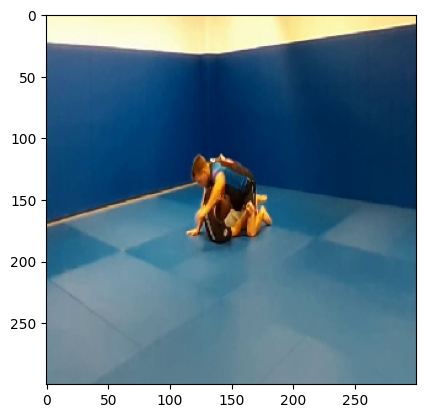

half_guard


In [ ]:
from random import randint

while True:
    try:
        random_n = str(randint(1, 1500000))

        while len(random_n) < 7:
            random_n = '0' + random_n

        image_path = image_folder + '/' + random_n + '.jpg'
        image = load_img(image_path, target_size=(300, 300))
        
        break
    except:
        continue

image_array = img_to_array(image)
image_array = image_array / 255.0
image_array = np.expand_dims(image_array, axis=0)

prediction = pose_detection_model.predict(image_array)
categories = train_generator.class_indices

categories_keys = list(categories.keys())

prob_by_category = {}

for i, prev in enumerate(prediction[0]):
    l = categories_keys[i]
    prob_by_category[l] = '{:.4f}%'.format(float(prev) * 100)

prob_by_category = dict(sorted(prob_by_category.items(), key=lambda item: float(item[1][:-1]), reverse=True))

print(prob_by_category)

label = categories_keys[np.argmax(prediction)]

plt.imshow(image)
plt.show()

print(label)
        
